# **Improving Campaign Response of Bank Customer by Targeted Marketing**

Author : Anissa Prameswari


---

# Introduction

The objective for this project is to Improve DM Response with the given dataset. With this being said we can use Machine Learning to predict the target's features importance, so the bank can offer suitable product and services to boost profitabiity and retain their customer.



# Import Data

Unfortunately, the dataset for this project is exclusive so the detail of the dataset is limited to the analytics that reported below.

In [184]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import seaborn as sns
import io
import scipy.stats as st
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier, plot_tree, plot_importance
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
import datetime
import graphviz

In [185]:
#Mounting
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [186]:
#Importing Data into DataFrame
df = pd.read_csv('drive/My Drive/Colab Notebooks/Data/cp_data_eng_full.csv')

In [ ]:
#Data attributes
df.info()
#Output: 69 features with customer_ID as unique value, datetime  variable is not in the right data type

We have 1292 customer in this dataset with 69 features several of them has missing values. The target is the 'Response' variable and there are several personal information we can see, such as ('Sex', 'Age', 'Card_type', 'Job', 'avg_charge', etc.) and several variables seems redundant on this personal feature such as 'On_the_job'.


In [188]:
df.head(3)

,NO,Customer_ID,Response,Sex,Age,Card_type,Shopping,Cashing,ETC,Card_contraction,...,charge_Wednesday,charge_Friday,charge_Thursday,charge_Saturday,charge_Sunday,generation,contraction_year,contraction_mon,contraction_day,contraction_day_JP
0,1,80000018,no reply,F,35.0,original,1.0,0.0,0.0,2003/3/22,...,8410.0,NaN,72300.0,6620.0,16920.0,30s,2003.0,3.0,7.0,Saturday
1,2,80000042,reply,M,39.0,affiliated card A,1.0,1.0,0.0,2003/1/21,...,90880.0,36020.0,NaN,19010.0,69110.0,30s,2003.0,1.0,3.0,Tuesday
2,3,80000234,no reply,F,43.0,affiliated card A,1.0,1.0,1.0,2003/2/16,...,8110.0,NaN,9470.0,NaN,21680.0,40s,2003.0,2.0,1.0,Sunday


## Addressing Missing Value

In [189]:
df.isnull().sum()

NO                      0
Customer_ID             0
Response              290
Sex                    61
Age                    61
                     ... 
generation            207
contraction_year      207
contraction_mon       207
contraction_day       207
contraction_day_JP    207
Length: 69, dtype: int64

This dataset contain so many missing values, for this step we should drop missing value in our target ('Response') first, then we can decide for the other missing value along with our analysis. 

In [190]:
#Remove the missing response
df.dropna(subset = ['Response'], inplace=True)

## Addressing Duplicate

In [191]:
#Show the duplicate in Customer_ID
df[df.duplicated('Customer_ID')]

,NO,Customer_ID,Response,Sex,Age,Card_type,Shopping,Cashing,ETC,Card_contraction,...,charge_Wednesday,charge_Friday,charge_Thursday,charge_Saturday,charge_Sunday,generation,contraction_year,contraction_mon,contraction_day,contraction_day_JP
1000,1000,80109887,no reply,M,44.0,affiliated card C,0.0,0.0,0.0,2003/3/25,...,NaN,NaN,10430.0,58370.0,35090.0,40s,2003.0,3.0,3.0,Tuesday


In [192]:
#Remove Duplicate
df.drop_duplicates(subset ='Customer_ID', keep = 'first', inplace = True)

## Addressing Different Data Type

Some column that has datetime data need to be converted into an appropriate data type. However, there are some missing value or abnormal data that need to be inspected before converting.

In [193]:
#There is an abnormal date in min_used _date, max_used_date
df[df['min_used_date'] == '41000']

,NO,Customer_ID,Response,Sex,Age,Card_type,Shopping,Cashing,ETC,Card_contraction,...,charge_Wednesday,charge_Friday,charge_Thursday,charge_Saturday,charge_Sunday,generation,contraction_year,contraction_mon,contraction_day,contraction_day_JP
1002,1002,80109889,no reply,M,200.0,original,0.0,1.0,0.0,2003/2/15,...,NaN,NaN,NaN,NaN,74310.0,40s,2003.0,2.0,7.0,Saturday


In [194]:
df[df['max_used_date'] == '20NA']

,NO,Customer_ID,Response,Sex,Age,Card_type,Shopping,Cashing,ETC,Card_contraction,...,charge_Wednesday,charge_Friday,charge_Thursday,charge_Saturday,charge_Sunday,generation,contraction_year,contraction_mon,contraction_day,contraction_day_JP
57,58,80005291,no reply,M,32.0,affiliated card C,1.0,0.0,0.0,2003/2/3,...,4540.0,82600.0,NaN,82570.0,30610.0,30s,2003.0,2.0,2.0,Monday


Since there's only two column we can remove them.

In [195]:
#Removing abnormal date
df = df.loc[df['min_used_date'] != '41000']
df= df[df['max_used_date'] != '20NA']

In [196]:
#Datetime conversion
df[['Card_contraction', 'min_used_date', 'max_used_date', 'expiration_date']] = df[['Card_contraction', 'min_used_date', 'max_used_date', 'expiration_date']].apply(pd.to_datetime)

In [ ]:
df.info()
#Output: all datetime had been converted, we still have missing values

Now we can do the analysis since all of the data already has correct data type and grouping them in our analysis can simplify our work.

In [198]:
#Group the Data for Analysis
df_datetime = ['min_used_date', 'max_used_date', 'Card_contraction', 'expiration_date']
df_numeric = ['Age', 'onlineservice_avg_mon', 'cashing_avg_mon', 'food_avg_mon', 'speciality_avg_mon', 'general_avg_mon', 'network_avg_mon', 'onlineshopping_avg_mon', 'beauty_avg_mon', 'amusement_avg_mon', 'travel_avg_mon', 'onlineservice_avg_lmon', 'cashing_avg_lmon', 'food_avg_mon.1', 'speciality_avg_lmon', 'general_avg_lmon', 'network_avg_lmon', 'onlineshopping_avg_lmon', 'beauty_avg_lmon', 'amusement_avg_lmon', 'travel_avg_lmon', 'shopping_avg', 'cashing_avg', 'ETC_avg', 'shopping_rec', 'cashing_rec', 'ETC_rec', 'max_charge', 'min_charge', 'avg_charge', 'charge_avg_per_mon', 'charge_lmon','charge_Monday','charge_Tuesday','charge_Wednesday','charge_Thursday','charge_Friday','charge_Saturday','charge_Sunday']
df_category = ['Response', 'Sex', 'Card_type', 'Shopping', 'Cashing', 'ETC', 'Card_grade', 'Job', 'On_the_job', 'marriage', 'questionnaire1', 'questionnaire2', 'questionnaire3', 'questionnaire4', 'questionnaire5', 'generation', 'contraction_year', 'contraction_day', 'contraction_mon', 'contraction_day_JP', 'No_function', 'No_member_store_use', 'No_category_use', 'No_records']

# Univariate Analysis

## Analysis for Numerical Values

### Missing value

In [ ]:
#Percentage of numeric missing values
(df[df_numeric].isnull().sum()/len(df[df_numeric]))*100

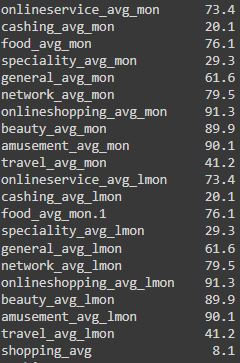

From the percentage of the missing value we can see a pattern that average and recent feature for same method or category of spending will have the same percentage of missing value. For example 'onlineservice_avg_mon' and 'onlineservice_avg_lmon'.

We can start by dropping out columns that has mssing values percentage more than 30% since this dataset contain relatively small data dropping all the missing values would resulted in a poor model. The many features in this dataset will also make the data more sparse and might lead to overfitting.

In [200]:
#Dropping feature that has missing value more than ~30%
df = df.drop(['onlineservice_avg_mon', 'food_avg_mon', 'general_avg_mon', 'network_avg_mon', 'onlineshopping_avg_mon', 'beauty_avg_mon', 'travel_avg_mon', 'amusement_avg_mon', 'onlineservice_avg_lmon', 'food_avg_mon.1', 'general_avg_lmon', 'network_avg_lmon', 'onlineshopping_avg_lmon', 'beauty_avg_lmon', 'speciality_avg_mon', 'speciality_avg_lmon', 'amusement_avg_lmon', 'travel_avg_lmon', 'ETC_avg', 'ETC_rec', 'charge_Monday', 'charge_Tuesday', 'charge_Wednesday', 'charge_Thursday', 'charge_Friday', 'charge_Saturday', 'charge_Sunday'], axis = 1)
df_numeric = ['Age', 'cashing_avg_mon', 'cashing_avg_lmon',  'shopping_avg', 'cashing_avg', 'shopping_rec', 'cashing_rec', 'max_charge', 'min_charge', 'avg_charge', 'charge_avg_per_mon', 'charge_lmon']

### Statistical Analysis

In [201]:
df[df_numeric].describe()

,Age,cashing_avg_mon,cashing_avg_lmon,shopping_avg,cashing_avg,shopping_rec,cashing_rec,max_charge,min_charge,avg_charge,charge_avg_per_mon,charge_lmon
count,1000.000000,799.000000,799.000000,919.000000,800.000000,919.000000,800.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,35.353000,25650.326658,25965.957447,25828.343993,25628.083413,24861.610446,25943.225000,55953.450000,6429.140000,23878.395000,26314.356000,26046.240000
std,11.615046,26498.516510,32248.156518,22853.193574,26489.485084,30238.621869,32234.383097,51485.870684,7440.241034,18233.165558,20595.105894,33481.845795
min,14.000000,2030.000000,2020.000000,2040.000000,2030.000000,2010.000000,2020.000000,2110.000000,2000.000000,2110.000000,2110.000000,2000.000000
25%,28.000000,8442.500000,6055.000000,9485.000000,8382.500000,6010.000000,6062.500000,16375.000000,2770.000000,9827.000000,10277.000000,5927.500000
50%,35.000000,18300.000000,15360.000000,19965.000000,18280.850000,14180.000000,15335.000000,40265.000000,4125.000000,19804.500000,21521.000000,14370.000000
75%,42.000000,33093.000000,32890.000000,33826.450000,33076.675000,32150.000000,32880.000000,75842.500000,7062.500000,32098.250000,35330.500000,32517.500000
max,200.000000,268490.000000,268490.000000,210800.000000,268490.000000,308330.000000,268490.000000,363860.000000,93320.000000,110525.000000,122530.000000,363860.000000


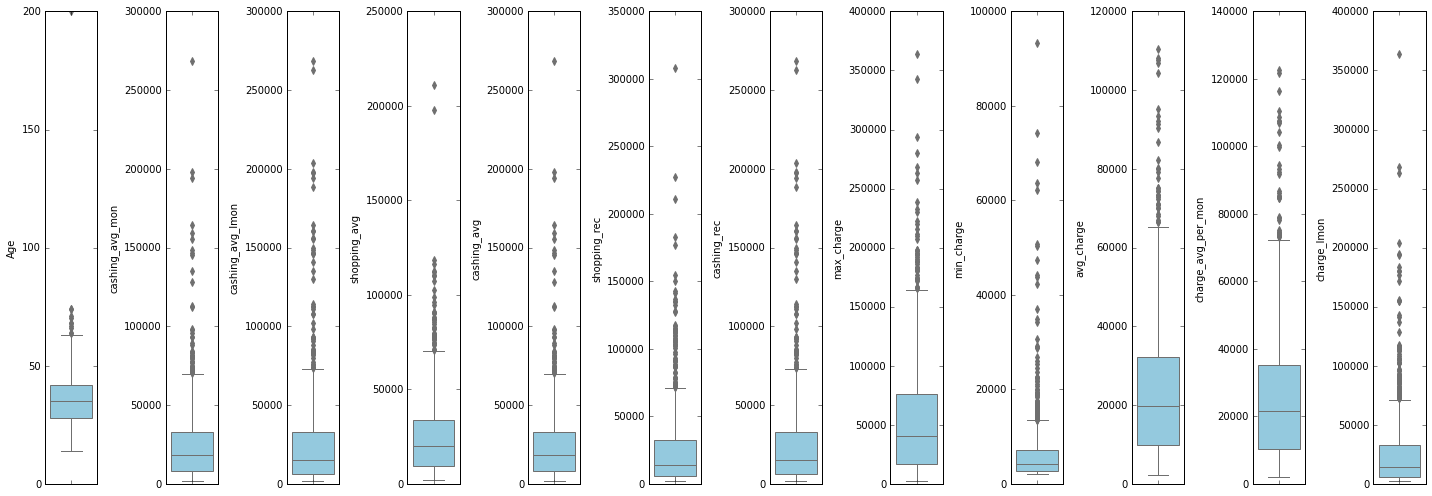

In [202]:
#Check outliers by boxplot
plt.figure(figsize=(20,7))
for i in range(0,len(df_numeric)):
  plt.subplot(1, len(df_numeric), i+1)
  sns.boxplot(y = df[df_numeric[i]], color = 'skyblue')
  plt.tight_layout()

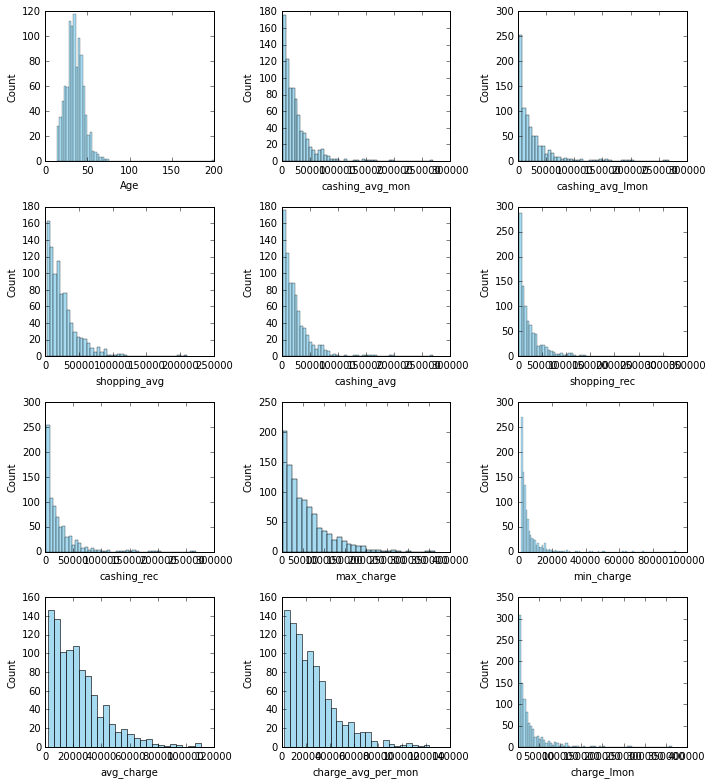

In [203]:
#Column Distribution using histogram
plt.figure(figsize=(10,11))
for i in range(0, len(df_numeric)):
  plt.subplot(4, 3, i+1)
  sns.histplot(x=df[df_numeric[i]], color = 'skyblue')
  plt.xlabel(df_numeric[i])
  plt.tight_layout()

Observation of numerical values:

*   'Age' has an outlier of 200 which is non-sensical, while other columns outlier still sensical since it's based on customer spending
*   Almost all of the column is right skewed.
*   Check if features that have a look-alike distribution is redundant such as:
1. 'avg_charge' and 'charge_avg_per_mon'; 'cashing_avg' and 'cashing_avg_mon'; 'cashing_rec' and 'cashing_avg_lmon'
2. Average of spending method and recent spending method

In [204]:
#Remove abnormal 'Age'
df = df.loc[df['Age'] != 200]

Since, the age outlier is abnormal we decided to drop the value. While other observation will be analyzed further in bivariate analysis.

## Analysis for Categorical Values

### Missing values for categorical features

In [ ]:
df[df_category].isnull().sum()/len(df[df_category])*100
#Output : Job (29.43%)

There are 29.42% missing values in Job, we can assume this is people whose Job is unknown so instead of dropping them we can fill the missing values with Unknown.
While other features doesn't have missing values anymore.

In [207]:
df['Job'] = df['Job'].fillna('Unknown')

### Statistical Analysis for categorical features

In [208]:
df[df_category].astype('category').describe()

,Response,Sex,Card_type,Shopping,Cashing,ETC,Card_grade,Job,On_the_job,marriage,...,questionnaire5,generation,contraction_year,contraction_day,contraction_mon,contraction_day_JP,No_function,No_member_store_use,No_category_use,No_records
count,999,999,999,999.0,999.0,999.0,999,999,999,999,...,999.0,999,999.0,999.0,999.0,999,999.0,999.0,999.0,999.0
unique,2,2,4,2.0,2.0,2.0,8,10,2,2,...,6.0,7,1.0,7.0,4.0,7,4.0,12.0,8.0,20.0
top,no reply,F,original,1.0,1.0,0.0,silver card,Unknown,working,unmarried,...,0.0,30s,2003.0,7.0,3.0,Saturday,2.0,3.0,3.0,3.0
freq,839,578,396,748.0,551.0,721.0,345,294,583,556,...,914.0,385,999.0,159.0,329.0,159,466.0,222.0,302.0,180.0


In [ ]:
#Value counts
for col in df_category:
    print(f"Column: {col}")
    print(df[col].value_counts())
    print("\n")

Observation of categorical variable:

*   Target is imbalance
*   'Card_grade' has several similar value that we convert into one
*   General payer 1,2,3 in 'Job' give same information
*   'contraction_year' only generate a single value
*   'On_the_job' and 'Job', 'Generation' and 'Age', 'contraction_day' and 'contraction_day_JP' check the correlation and if one of them redundant to decide which one should we drop
*   Correlation on 'No_function' with: 'No_member_store_use', 'No_category_use', and 'No_records'
*   'questionnaire1-5' seems like only filled with customer who gave response to the DM



In [210]:
#Change general payer 1,2,3 into general in 'Job'
df['Job'] = df['Job'].replace(['general payer1','general payer2', 'general payer3'], 'general payer')

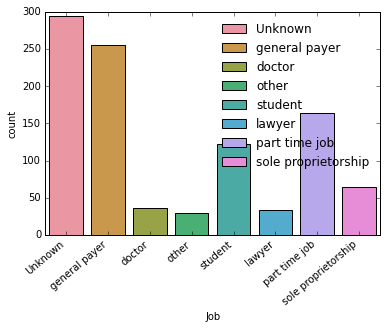

<Figure size 1080x360 with 0 Axes>

In [211]:
#Final job category
ax = sns.countplot(x="Job", hue = "Job", data=df, dodge = False)
plt.figure(figsize =(15,5))
ax.legend(frameon = False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()

In [212]:
#Sort similar grade of cards into same grade
df['Card_grade'] = df['Card_grade'].replace('gold card(superior)', 'gold card')
df['Card_grade'] = df['Card_grade'].replace(['loyal(platinum)card', 'platinum loyal card', 'loyal card'], 'platinum card')
df['Card_grade'] = df['Card_grade'].replace('silver card (classic)', 'silver card')

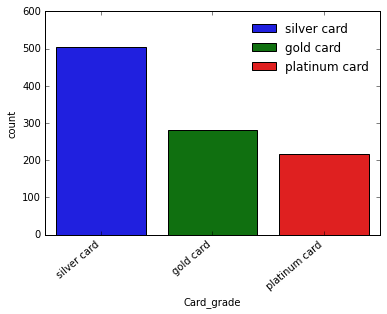

<Figure size 1080x360 with 0 Axes>

In [213]:
#Final Card_Grade Category
ax = sns.countplot(x="Card_grade", hue = 'Card_grade', data=df, dodge = False)
plt.figure(figsize =(15,5))
ax.legend(frameon = False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()

### Missing value for datetime features

In [214]:
df[df_datetime].isnull().sum()/len(df[df_category])*100

min_used_date       0.0
max_used_date       0.0
Card_contraction    0.0
expiration_date     0.0
dtype: float64

### Statistical value for datetime features

In [215]:
#Stats for datetime values
df[df_datetime].describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  


,min_used_date,max_used_date,Card_contraction,expiration_date
count,999,999,999,999
unique,34,33,101,5
top,2010-04-01 00:00:00,2012-11-01 00:00:00,2003-04-09 00:00:00,2019-03-16 00:00:00
freq,112,157,19,325
first,2010-01-01 00:00:00,2010-04-01 00:00:00,2003-01-01 00:00:00,2019-01-16 00:00:00
last,2012-10-01 00:00:00,2012-12-01 00:00:00,2003-04-11 00:00:00,2019-12-15 00:00:00


Observation:
1. max_used_date and min_used_date can be change into a single variable such as length_of_use
2. Card_contraction information is only for 3 months from 2003
3. Expiration_date information is only from 2019

In [216]:
#Length_of_use to reduce features
df['length_of_use'] = df['max_used_date'] - df['min_used_date']
df['length_of_use'] = pd.to_numeric(df['length_of_use'])
#Convert from ns to days for better understanding in insight
df['length_of_use'] = df['length_of_use']/10**9/3600/24

In [ ]:
#Check if there is customer that use card less than a day
df.loc[df['length_of_use'] == 0]

#Output: there are 52 of them

Don't drop them since there's a possibility it's a new customer or ETC only card.

In [218]:
df = df.drop(['min_used_date', 'max_used_date'], axis =1)

## Statistical Analysis of Transformed data

In [219]:
df[df_numeric].describe()

,Age,cashing_avg_mon,cashing_avg_lmon,shopping_avg,cashing_avg,shopping_rec,cashing_rec,max_charge,min_charge,avg_charge,charge_avg_per_mon,charge_lmon
count,999.000000,798.000000,798.000000,918.000000,799.000000,918.000000,799.000000,999.000000,999.000000,999.000000,999.000000,999.000000
mean,35.188188,25580.870927,25797.493734,25784.297527,25558.685895,24867.102397,25774.943680,55848.898899,6423.053053,23845.176176,26265.998999,25891.911912
std,10.385294,26442.259819,31914.641346,22826.587759,26433.208164,30254.646593,31901.007137,51405.341178,7441.476112,18211.997278,20548.543806,33140.854768
min,14.000000,2030.000000,2020.000000,2040.000000,2030.000000,2010.000000,2020.000000,2110.000000,2000.000000,2110.000000,2110.000000,2000.000000
25%,28.000000,8426.250000,6047.500000,9470.000000,8355.000000,6005.000000,6055.000000,16370.000000,2770.000000,9819.000000,10274.000000,5915.000000
50%,35.000000,18280.500000,15335.000000,19933.000000,18261.700000,14170.000000,15310.000000,40240.000000,4120.000000,19778.000000,21466.000000,14330.000000
75%,42.000000,33060.000000,32857.500000,33687.000000,33060.000000,32155.000000,32845.000000,75830.000000,7055.000000,32060.000000,35228.500000,32510.000000
max,74.000000,268490.000000,268490.000000,210800.000000,268490.000000,308330.000000,268490.000000,363860.000000,93320.000000,110525.000000,122530.000000,363860.000000


In [220]:
df[df_category].astype('category').describe()

,Response,Sex,Card_type,Shopping,Cashing,ETC,Card_grade,Job,On_the_job,marriage,...,questionnaire5,generation,contraction_year,contraction_day,contraction_mon,contraction_day_JP,No_function,No_member_store_use,No_category_use,No_records
count,999,999,999,999.0,999.0,999.0,999,999,999,999,...,999.0,999,999.0,999.0,999.0,999,999.0,999.0,999.0,999.0
unique,2,2,4,2.0,2.0,2.0,3,8,2,2,...,6.0,7,1.0,7.0,4.0,7,4.0,12.0,8.0,20.0
top,no reply,F,original,1.0,1.0,0.0,silver card,Unknown,working,unmarried,...,0.0,30s,2003.0,7.0,3.0,Saturday,2.0,3.0,3.0,3.0
freq,839,578,396,748.0,551.0,721.0,503,294,583,556,...,914.0,385,999.0,159.0,329.0,159,466.0,222.0,302.0,180.0


In [221]:
df_datetime = ['Card_contraction', 'expiration_date']
df[df_datetime].describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  


,Card_contraction,expiration_date
count,999,999
unique,101,5
top,2003-04-09 00:00:00,2019-03-16 00:00:00
freq,19,325
first,2003-01-01 00:00:00,2019-01-16 00:00:00
last,2003-04-11 00:00:00,2019-12-15 00:00:00


Seems like contraction_day, contraction_year, contraction_month is composite variable from Card_contraction, check in multivaariate analysis.

# Multivariate Analysis

For multivariate analysis to drop redundant feature we need to neglect dropping very high and very low correlated features, as long as the correlation does not equal to 0 or 1. This is because we want to see the features importance from the model.

## Relationship between numeric variable with numeric variable

In [222]:
def scatter(x,y):
  plt.scatter(df[x],df[y], edgecolors=['skyblue','red'])
  plt.xlabel(x)
  plt.ylabel(y)
  plt.show()

In [223]:
def correlation(x,y):
  print(df[[x,y]].corr())
  print('\n')

1. avg_charge with avg_charge_per_mon

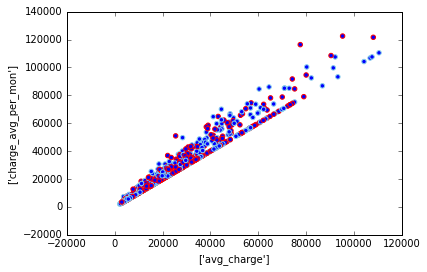

In [224]:
scatter(['avg_charge'],['charge_avg_per_mon'])

In [225]:
correlation('avg_charge','charge_avg_per_mon')

                    avg_charge  charge_avg_per_mon
avg_charge            1.000000            0.980227
charge_avg_per_mon    0.980227            1.000000




Both feature has very strong correlation, but not equal to 1.

2. Correlation between each spending method category and their recent record

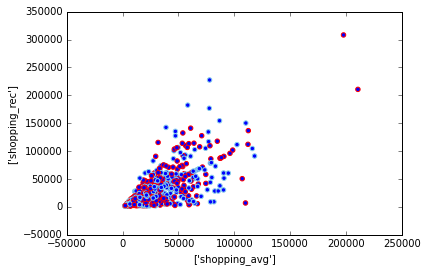

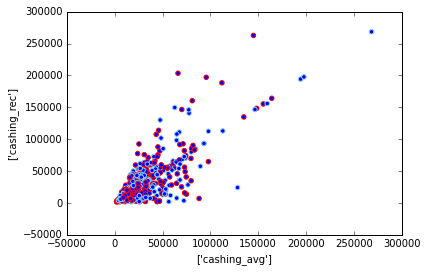

In [226]:
scatter(['shopping_avg'],['shopping_rec'])
scatter(['cashing_avg'],['cashing_rec'])

In [227]:
correlation('shopping_avg','shopping_rec')
correlation('cashing_avg','cashing_rec')

              shopping_avg  shopping_rec
shopping_avg      1.000000      0.739679
shopping_rec      0.739679      1.000000


             cashing_avg  cashing_rec
cashing_avg     1.000000     0.830853
cashing_rec     0.830853     1.000000




3. Correlation between cashing_avg and cashing_avg_mon

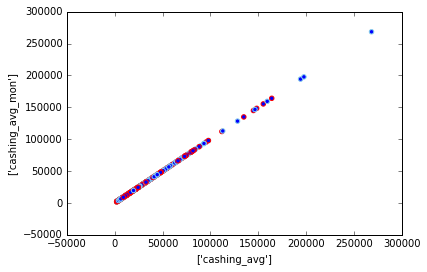

In [228]:
scatter(['cashing_avg'],['cashing_avg_mon'])

In [229]:
correlation('cashing_avg','cashing_avg_mon')

                 cashing_avg  cashing_avg_mon
cashing_avg              1.0              1.0
cashing_avg_mon          1.0              1.0




4. Correlation between 'cashing_rec' and 'cashing_avg_lmon'

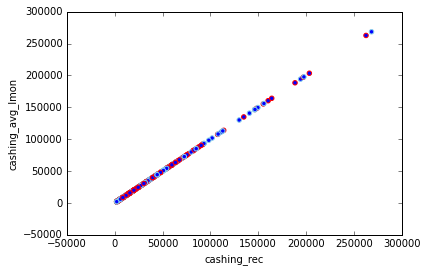

In [230]:
scatter('cashing_rec', 'cashing_avg_lmon')

In [231]:
correlation('cashing_rec', 'cashing_avg_lmon')

                  cashing_rec  cashing_avg_lmon
cashing_rec               1.0               1.0
cashing_avg_lmon          1.0               1.0




For ('cashing_avg','cashing_avg_mon') and ('cashing_rec','cashing_avg_lmon') the correlation is one, so we can drop the redundant feature.

In [232]:
#Drop redundant features
df = df.drop(['cashing_avg_lmon','cashing_avg_mon'], axis = 1)

5. Heatmap correlation of numerical features and with target

In [233]:
df['Response'] = df['Response'].replace({ 'reply' : 1, 'no reply' : 0})

In [234]:
df_numeric = ['Age', 'Response', 'shopping_avg', 'cashing_avg', 'shopping_rec', 'cashing_rec', 'max_charge', 'min_charge', 'avg_charge', 'charge_avg_per_mon', 'charge_lmon', 'length_of_use']

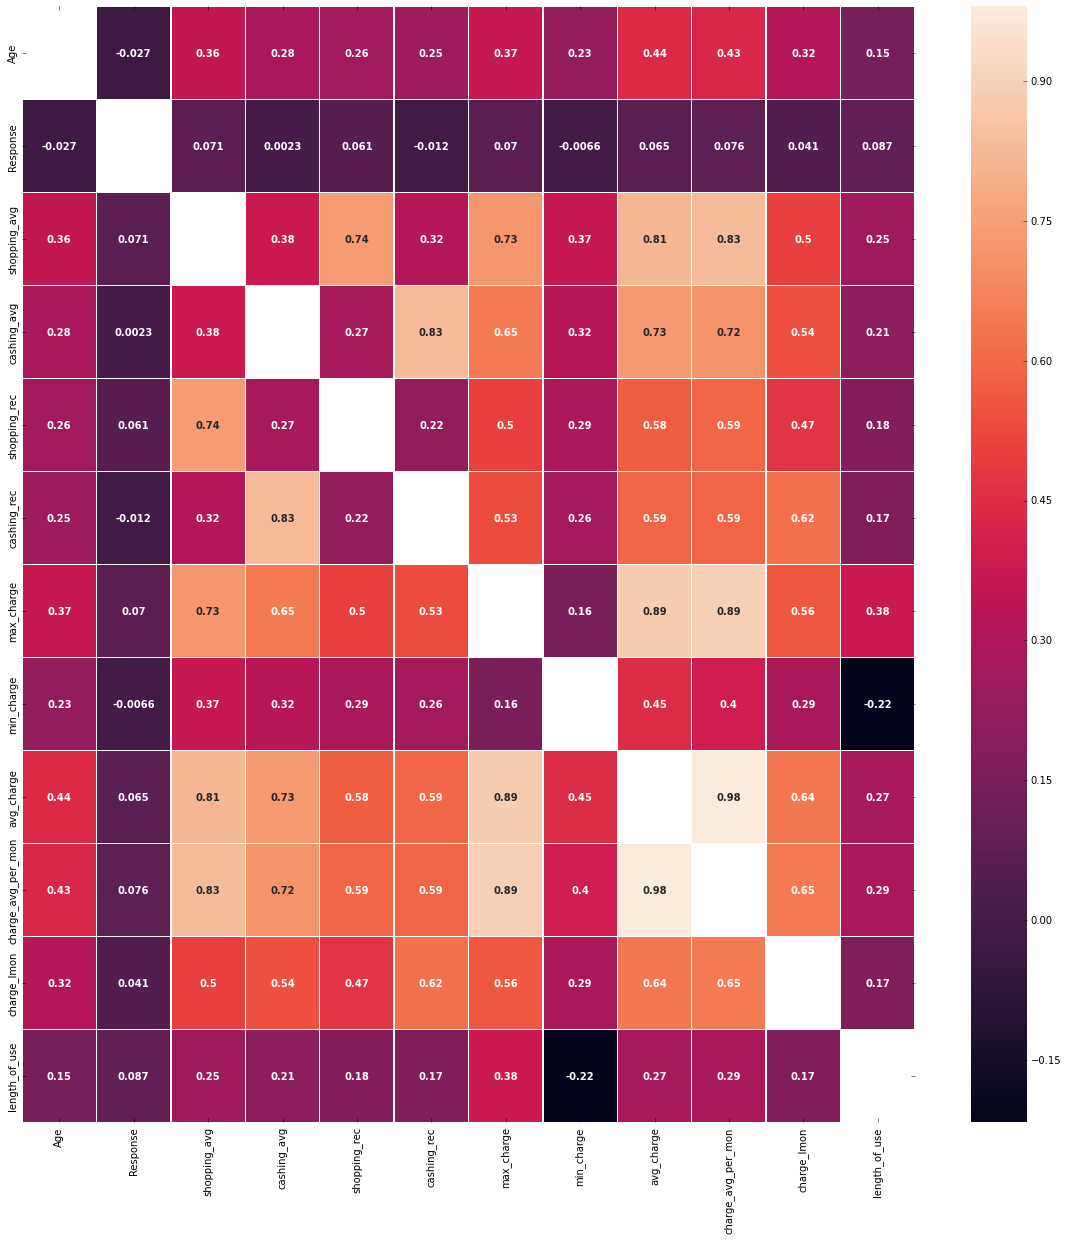

In [235]:
df_corr = df[df_numeric]
df_corr = df_corr.corr()
max_column_u = np.max(df_corr)
fig, ax = plt.subplots(figsize = (20,20))
sns.heatmap(df_corr, mask = df_corr == max_column_u, annot=True, linewidth = .5, ax=ax,
            annot_kws={"weight" : "bold"}, xticklabels="auto", yticklabels="auto")

Seems there are no more redundant features for numerical values. We can also see here that the correlation of numerical features towards our target is very low.

## Relationship between category to category variable

In [236]:
def crosstab(x,y):
  crosstab = pd.crosstab(x,y)
  chi_square = st.chi2_contingency(crosstab)

  print(crosstab)
  print('\n')
  print(f'Chi-square =\n {chi_square}')

1. Chi-square of Job and On_the_Job

---

Output: p-value = 0, dof = 7, rejecting null-hypothesis

In [ ]:
crosstab(df['Job'],df['On_the_job'])

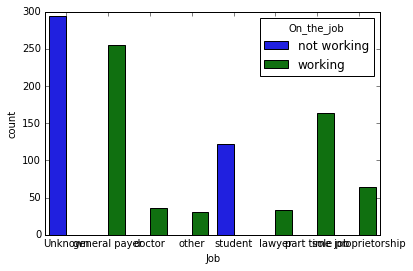

In [238]:
sns.countplot(x = 'Job', hue = 'On_the_job', data = df)
#Redundant drop one of them

From the countplot we can see we don't 'On_the_job' as 'Job' has already gave us the info we needed.

In [239]:
df = df.drop(['On_the_job'], axis =1)

2. Questionnaire and Response

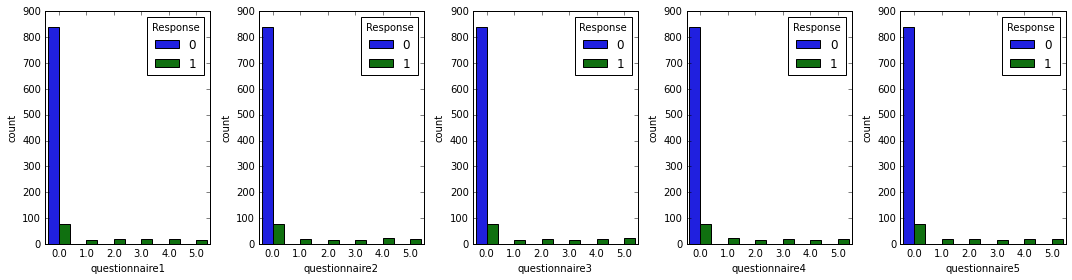

In [240]:
features = ['questionnaire1', 'questionnaire2', 'questionnaire3', 'questionnaire4', 'questionnaire5']
plt.figure(figsize=(15,4))
for i in range(0,len(features)):
  plt.subplot(1, len(features), i+1)
  sns.countplot(x = features[i], hue = 'Response', data = df)
  plt.tight_layout()

Since questionnaire only filled with responsive customer we should drop them

In [241]:
df = df.drop(features, axis=1)

3. Check relationship of 'contraction_day' with 'contraction_day_JP' and  'Card_contraction' relationship with: 'contraction_day_JP', 'contraction_mon' and 'contraction_year'

In [242]:
pd.crosstab(df['contraction_day'] , df['contraction_day_JP'])
#Drop one of them

contraction_day_JP,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
contraction_day,,,,,,,
1.0,0,0,0,156,0,0,0
2.0,0,137,0,0,0,0,0
3.0,0,0,0,0,0,123,0
4.0,0,0,0,0,0,0,152
5.0,0,0,0,0,154,0,0
6.0,118,0,0,0,0,0,0
7.0,0,0,159,0,0,0,0


In [243]:
#Get day, month and year from Card_contraction
card_contraction_dayname = df['Card_contraction'].dt.day_name()
card_contraction_month = pd.to_datetime(df['Card_contraction']).dt.month
card_contraction_year = pd.to_datetime(df['Card_contraction']).dt.year

In [244]:
pd.crosstab(df['contraction_day_JP'], card_contraction_dayname)
#We should drop two feature from card_contraction, contraction_day, and contraction_day_JP

Card_contraction,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
contraction_day_JP,,,,,,,
Friday,118,0,0,0,0,0,0
Monday,0,137,0,0,0,0,0
Saturday,0,0,159,0,0,0,0
Sunday,0,0,0,156,0,0,0
Thursday,0,0,0,0,154,0,0
Tuesday,0,0,0,0,0,123,0
Wednesday,0,0,0,0,0,0,152


In [245]:
pd.crosstab(df['contraction_mon'], card_contraction_month)

Card_contraction,1,2,3,4
contraction_mon,,,,
1.0,310,0,0,0
2.0,0,251,0,0
3.0,0,0,329,0
4.0,0,0,0,109


In [246]:
pd.crosstab(df['contraction_year'], card_contraction_year)
#Contraction year doesn't give any info

Card_contraction,2003
contraction_year,
2003.0,999


'Card_contraction' proven to be a composite variable from 'contraction_day', 'contraction_month', 'contraction_year'

In [247]:
df = df.drop(['Card_contraction', 'contraction_year', 'contraction_day_JP'], axis=1)

5. Correlation of 'No_function' with 'No_member_store_use', 'No_category_use', and 'No_records'

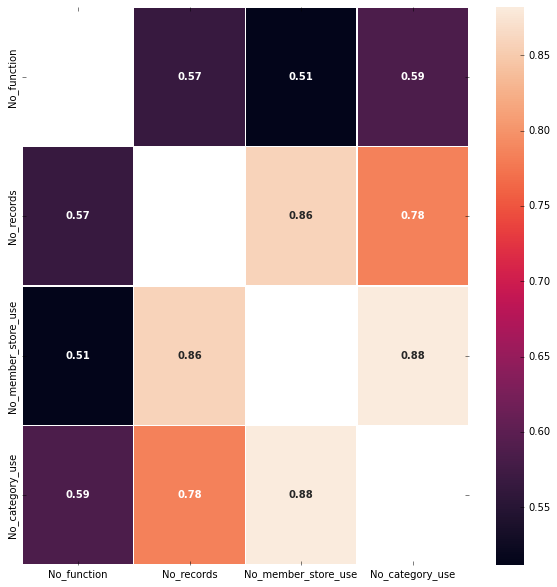

In [248]:
No_use_corr = df[['No_function', 'No_records', 'No_member_store_use', 'No_category_use']].corr()
max_column_u = np.max(No_use_corr)
fig, ax = plt.subplots(figsize = (10,10))
sns.heatmap(No_use_corr, mask = No_use_corr == max_column_u, annot=True, linewidth = .5, ax=ax,
            annot_kws={"weight" : "bold"}, xticklabels="auto", yticklabels="auto")

## Relationship between continous and category variable

1. Age and Generation

In [ ]:
pd.crosstab(df['Age'], df['generation'])
#Show output with boxplot for a better visualization

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


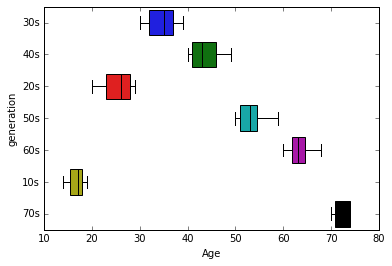

In [250]:
sns.boxplot(df['Age'], df['generation'])

Drop generation as it's only show the age in 10 years bins

In [251]:
df = df.drop(['generation'], axis=1)

# Modelling

In [ ]:
df.info()

In [ ]:
df.isnull().sum()/len(df)*100

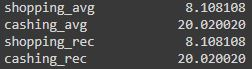

After analysis, our dataset have 34 features where 4 of them still have several missing values. We can impute them with 0 as it's more make sense for null values in people who didn't spend any cashing and shopping in the window of observation time of the data.

### Addressing Missing Value

In [254]:
df[['shopping_avg', 'shopping_rec', 'cashing_avg', 'cashing_rec']] = df[['shopping_avg', 'shopping_rec', 'cashing_avg', 'cashing_rec']].fillna(0)

Since the features that has missing values are average of each category or transaction method, we can impute them with median value. This is because the numerical values are right-skewed.

In [255]:
df = df.drop(['NO', 'Customer_ID'], axis=1)

In [256]:
df.head(3)

,Response,Sex,Age,Card_type,Shopping,Cashing,ETC,Card_grade,Job,marriage,...,No_member_store_use,No_category_use,max_charge,min_charge,avg_charge,charge_avg_per_mon,charge_lmon,contraction_mon,contraction_day,length_of_use
0,0,F,35.0,original,1.0,0.0,0.0,silver card,Unknown,married,...,4.0,4.0,72300.0,6620.0,28656.0,28656.0,8410.0,3.0,7.0,853.0
1,1,M,39.0,affiliated card A,1.0,1.0,0.0,gold card,general payer,unmarried,...,7.0,6.0,48770.0,2430.0,22815.0,29660.0,13810.0,1.0,3.0,915.0
2,0,F,43.0,affiliated card A,1.0,1.0,1.0,silver card,Unknown,married,...,4.0,4.0,21680.0,6380.0,11912.0,11912.0,6380.0,2.0,1.0,792.0


For interpretable and modeling purpose we should convert expiration_date into expiration_day and expiration_month.

In [257]:
df['expiration_day'] = df['expiration_date'].dt.dayofweek
df['expiration_month'] = pd.to_datetime(df['expiration_date']).dt.month

In [258]:
#To show us the day in case expiration_date is important
exp_day = df['expiration_date'].dt.day_name()

In [259]:
df = df.drop(['expiration_date'], axis=1)

### Encoding

In [ ]:
df.info()

We do One Hot Encoding for all features to simplify us with the feature importances interpretation after modeling.

In [261]:
new_df =pd.get_dummies(data=df,columns=['Sex', 'marriage', 'Card_type', 'Card_grade', 'Job'], drop_first=True)
new_df.head()

,Response,Age,Shopping,Cashing,ETC,shopping_avg,cashing_avg,shopping_rec,cashing_rec,No_records,...,Card_type_original,Card_grade_platinum card,Card_grade_silver card,Job_doctor,Job_general payer,Job_lawyer,Job_other,Job_part time job,Job_sole proprietorship,Job_student
0,0,35.0,1.0,0.0,0.0,44610.0,23720.0,16920.0,8410.0,5.0,...,1,0,1,0,0,0,0,0,0,0
1,1,39.0,1.0,1.0,0.0,27272.0,23174.0,54060.0,13810.0,13.0,...,0,0,0,0,1,0,0,0,0,0
2,0,43.0,1.0,1.0,1.0,12510.0,11015.0,6380.0,8110.0,5.0,...,0,0,1,0,0,0,0,0,0,0
3,0,45.0,1.0,1.0,1.0,3860.0,0.0,3860.0,0.0,1.0,...,1,0,1,0,0,0,0,0,0,0
4,0,33.0,1.0,0.0,0.0,5270.0,11590.0,5270.0,13200.0,3.0,...,0,0,0,0,1,0,0,0,0,0


In [ ]:
df.info()

#Output : Final feature after one Hot Encoding is 36 with 999 data.

### Split the features and target

In [263]:
# Percentage of target class
target = df['Response'].value_counts().reset_index()
target.rename(columns={'index' : 'Response', 'Response':'freq'}, inplace = True)
target['percentage'] = round((target['freq']/target['freq'].sum())*100,2)
target

,Response,freq,percentage
0,0,839,83.98
1,1,160,16.02


The target of this dataset is imbalance yet since the data is very small oversampling will introduce dependent observation for more than half of the data in minority class which won't be good for our model.

In [264]:
X = new_df.drop(['Response'],axis=1).to_numpy()
y = new_df['Response'].to_numpy()
y = y.reshape(len(y),)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

## 1. Baseline - Dummy Classifier

In [265]:
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score, recall_score, classification_report, plot_confusion_matrix, plot_roc_curve, precision_score
from sklearn.dummy import DummyClassifier

clf_dummy = DummyClassifier()
clf_dummy.fit(X_train, y_train)
y_pred = clf_dummy.predict(X_test)

In [266]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      1.00      0.94       176
           1       0.00      0.00      0.00        24

    accuracy                           0.88       200
   macro avg       0.44      0.50      0.47       200
weighted avg       0.77      0.88      0.82       200



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision in our model is conversion rate of DM Response, while recall is capture rate of the DM Response. We can see that the baseline model has very bad recall and precision since we didn't work out the imbalance target.

### Finding out the best method

The methods that we are going to focus on will be methods that aren't affected with multicollinearity and imbalance data, such as root-tree algorithm. This will give us better recall and precision and help us better in selecting features that are more important for our insight.

In [267]:
clf = [RandomForestClassifier(random_state=42),
      XGBClassifier(random_state = 42),
       DecisionTreeClassifier(random_state=42)]

ml_method = pd.DataFrame(columns = ['Method', 'Recall','Precision', 'F1 Score','AUC'])

In [268]:
for model in clf:
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    method = str(type(model)).split('.')[-1][:-2]
    

    auc = roc_auc_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    precision = precision_score(y_test, preds)
    recall = recall_score(y_test, preds)
    
    
    ml_method = ml_method.append({'Method': method, 
                    'Recall': recall,
                    'Precision': precision,
                    'F1 Score': f1,
                    'AUC':auc},
                     ignore_index=True)

In [269]:
ml_method

,Method,Recall,Precision,F1 Score,AUC
0,RandomForestClassifier,0.333333,0.888889,0.484848,0.663826
1,XGBClassifier,0.500000,0.800000,0.615385,0.741477
2,DecisionTreeClassifier,0.458333,0.647059,0.536585,0.712121


Random Forest Classifier

In [270]:
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.99      0.95       176
           1       0.89      0.33      0.48        24

    accuracy                           0.92       200
   macro avg       0.90      0.66      0.72       200
weighted avg       0.91      0.92      0.90       200



XGBoost Classifier

In [271]:
xgb_clf = XGBClassifier(random_state=42)
xgb_clf.fit(X_train, y_train)
y_pred = xgb_clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       176
           1       0.80      0.50      0.62        24

    accuracy                           0.93       200
   macro avg       0.87      0.74      0.79       200
weighted avg       0.92      0.93      0.92       200



Decision Tree Classifier

In [272]:
dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(X_train, y_train)
y_pred = dt_clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       176
           1       0.65      0.46      0.54        24

    accuracy                           0.91       200
   macro avg       0.79      0.71      0.74       200
weighted avg       0.90      0.91      0.90       200



The target of our data is imbalanced resulting in poorly predicted recall and precision. We can try hyperparameter tuning for the methods and as both metrics is as important in this project than it's best to focus on XGBClassifier and DecisionTreeClassifier since Random Forest gave us a very poor score in recall.

## Hyperparameter Tuning

### Decision Tree

In [273]:
dt_clf = DecisionTreeClassifier(random_state=42)

In [274]:
from sklearn.model_selection import GridSearchCV

parameters = {'criterion': ['gini', 'entropy'], 
        'max_depth': [1, 2, 3, 4],
        'min_samples_leaf': [2, 3]
       }

dt_gridcv = GridSearchCV(dt_clf, parameters, scoring='recall')
dt_gridcv.fit(X_train,  y_train)
dt_gridcv.best_params_

{'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 2}

In [275]:
#Model Classification Report Summary

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay

def model_report(model):
  
#Model Score Summary  
  y_pred = model.best_estimator_.predict(X_test)
  print('Classification Report')
  print(classification_report(y_test, y_pred))
  print("-----------------------------")
  
  print('Model AUC score: {0:0.3f}'. format(roc_auc_score(y_test, y_pred)))
  print('Model F1 score: {0:0.3f}'. format(f1_score(y_test, y_pred)))
  print('Model precision score: {0:0.3f}'. format(precision_score(y_test, y_pred)))
  print('Model recall score: {0:0.3f}'. format(recall_score(y_test, y_pred)))

  print('\n')
  print('Confusion Matrix and ROC-AUC Display')
  print("-----------------------------")
#Confusion Matrix and ROC-AUC Score for model
  fig, ax = plt.subplots(ncols=2, figsize=(10,7))
  y_pred = model.best_estimator_.predict(X_test)

  cm = confusion_matrix(y_test, y_pred, labels=model.best_estimator_.classes_)
  disp_con = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=model.best_estimator_.classes_)
  disp_roc = RocCurveDisplay.from_estimator(model.best_estimator_, X_test, y_test, ax = ax[1])
  disp_con.plot(ax=ax[0])

Classification Report
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       176
           1       0.55      0.67      0.60        24

    accuracy                           0.90       200
   macro avg       0.75      0.80      0.77       200
weighted avg       0.91      0.90      0.90       200

-----------------------------
Model AUC score: 0.796
Model F1 score: 0.604
Model precision score: 0.552
Model recall score: 0.667


Confusion Matrix and ROC-AUC Display
-----------------------------


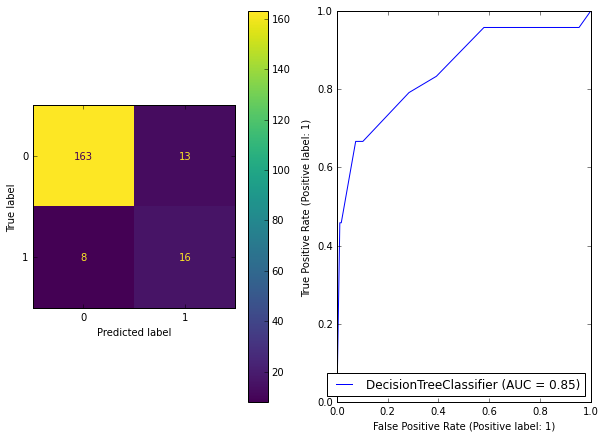

In [276]:
model_report(dt_gridcv)

In [ ]:
dt_clf = dt_gridcv.best_estimator_
dt_clf.fit(X,y)
plt.figure(figsize = (20,16))
tree.plot_tree(dt_clf)

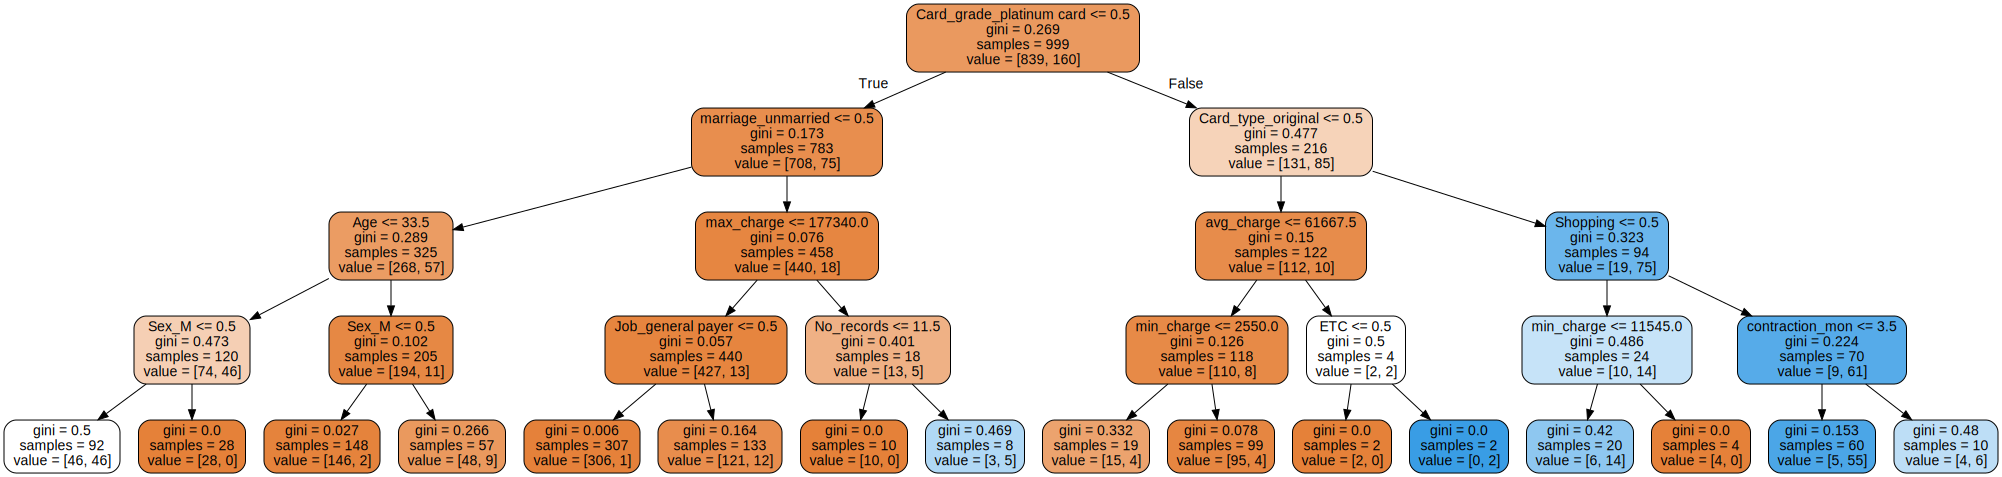

In [278]:
dot_data = tree.export_graphviz(dt_clf, feature_names=new_df.drop(columns = 'Response').columns, filled=True, rounded=True) 
graph = graphviz.Source(dot_data) 
graph

Decision Tree Classifier had a slightly better F1-Score and AUC after hyperparameter tuning. However, we see a drawback in precision indicating that the improvement in recall is a scarifice from precision. We can also see from the Decision Tree visualization that overall the nodes can separate each class pretty well, but several nodes that still has poor gini score.

### XGBoost Classifier

In [279]:
xgb_clf = XGBClassifier(random_state =42)

Since XGBClassifier has a heavy computational algorithm, we can use RandomizedCV.

In [280]:
from sklearn.model_selection import RandomizedSearchCV

parameters = {
    'max_depth': range(1, 7, 1),
    'n_estimators': (50, 100, 200),
    'learning_rate': [0.001, 0.01, 0.05],
    'reg_lambda' : [1,2],
    'subsample' : [0.6, 0.8]
       }

xgb_gridcv = RandomizedSearchCV(xgb_clf, parameters, cv=5, scoring='recall', n_iter=5)

xgb_gridcv.fit(X_train,  y_train)
xgb_gridcv.best_params_

{'subsample': 0.8,
 'reg_lambda': 1,
 'n_estimators': 50,
 'max_depth': 6,
 'learning_rate': 0.01}

Classification Report
              precision    recall  f1-score   support

           0       0.95      0.96      0.96       176
           1       0.70      0.67      0.68        24

    accuracy                           0.93       200
   macro avg       0.83      0.81      0.82       200
weighted avg       0.92      0.93      0.92       200

-----------------------------
Model AUC score: 0.813
Model F1 score: 0.681
Model precision score: 0.696
Model recall score: 0.667


Confusion Matrix and ROC-AUC Display
-----------------------------


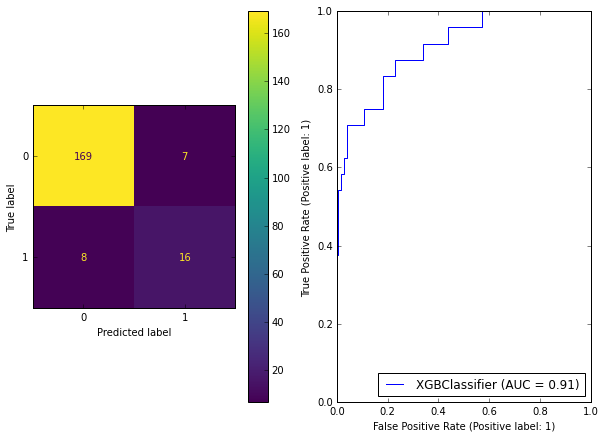

In [281]:
model_report(xgb_gridcv)

While XGBoostClassifier performance score doesn't show much difference after hyperparamter tuning. However, comparing all the metrics we can see that XGBoost Classifier is a better model for this dataset.

<function matplotlib.pyplot.show(*args, **kw)>

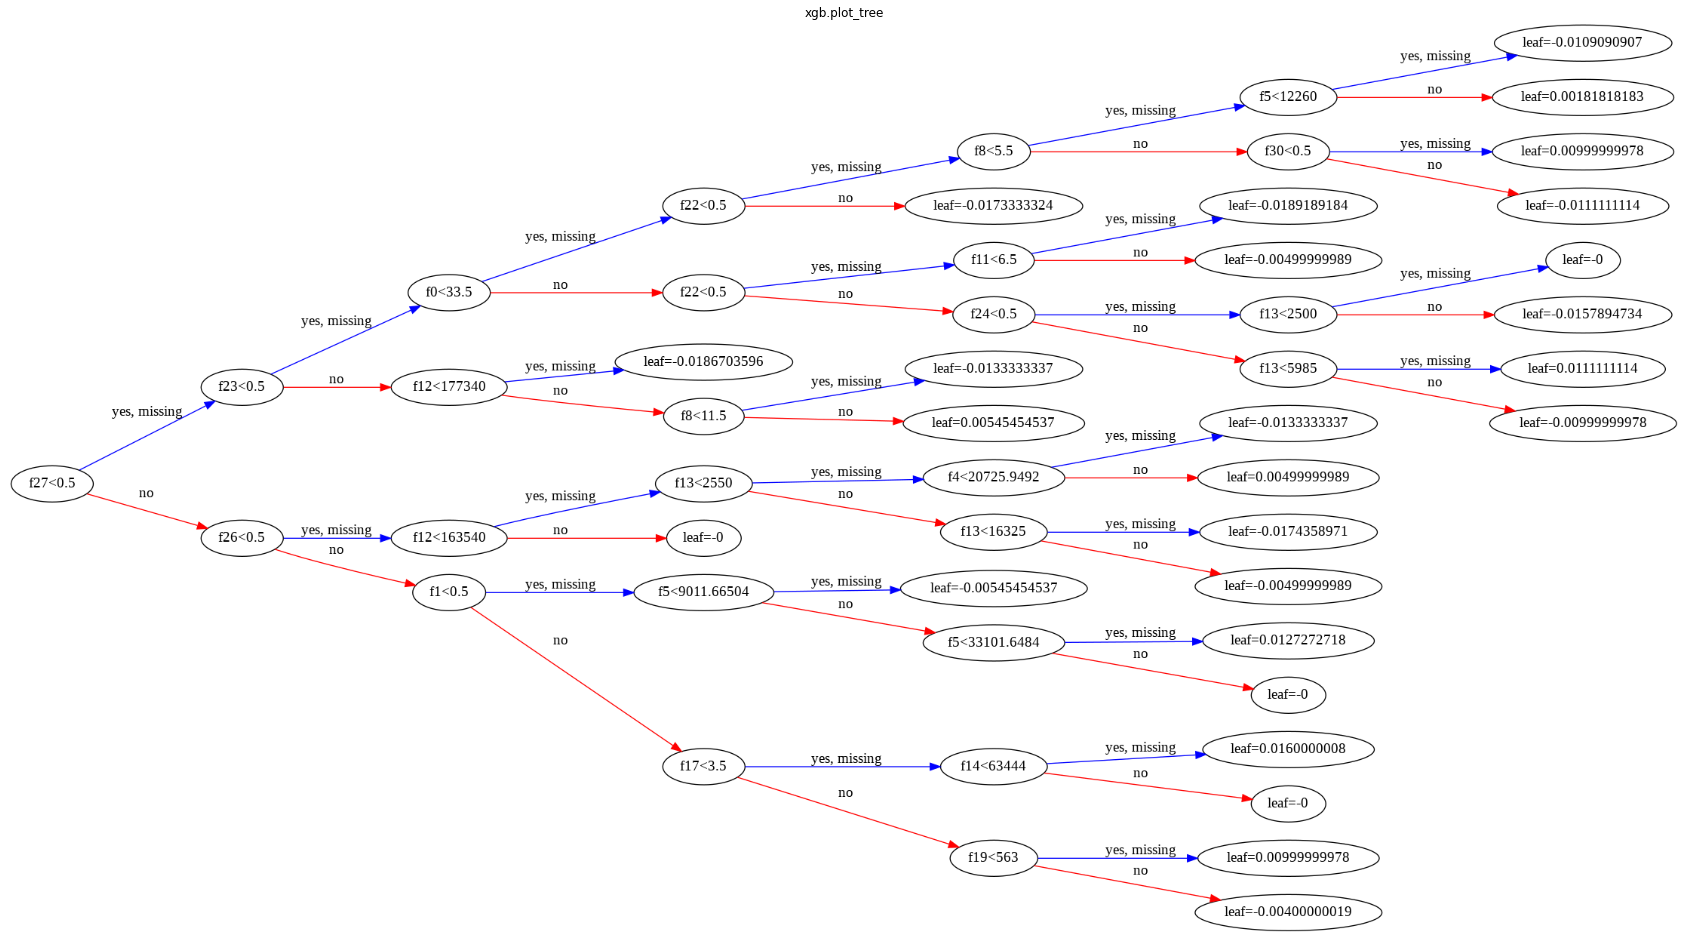

In [282]:
import xgboost
xgb_clf = xgb_gridcv.best_estimator_
xgb_clf.fit(X,y)

ax = xgboost.plot_tree(xgb_clf, num_trees = 0, rankdir = 'LR')
ax.figure.set_size_inches(30,30)
plt.title("xgb.plot_tree")
plt.show

**Feature Importance**

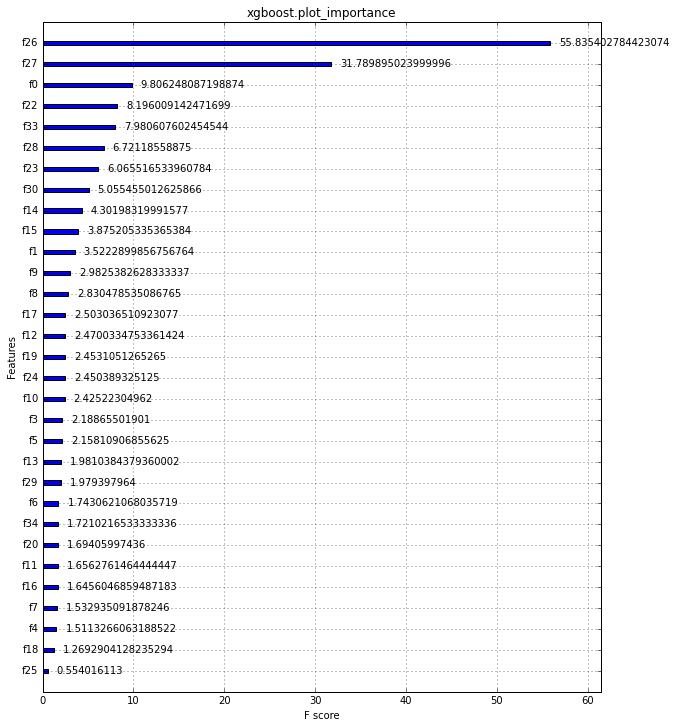

In [283]:
ax = xgboost.plot_importance(xgb_clf, importance_type = 'gain')
fig = ax.figure.set_size_inches(10,12)
plt.title("xgboost.plot_importance")
plt.show()

Now, we can match this output to the features in the data.

In [284]:
def xgb_importances(model, im_type):
  ax = xgboost.plot_importance(model, importance_type = im_type)

  feats = new_df.drop(columns = 'Response').columns
  dict_feats = dict(enumerate(feats))

  list_ylabel = list(ax.get_yticklabels())
  list_ylabel = [ list_ylabel[i].get_text().lstrip('f') for i in range (len(list_ylabel))]
  list_ylabel = [ dict_feats[int(i)] for i in list_ylabel]

  ax.set_yticklabels(list_ylabel)
  fig = ax.figure.set_size_inches(10,12)
  plt.title("xgboost.plot_importance")
  plt.show()

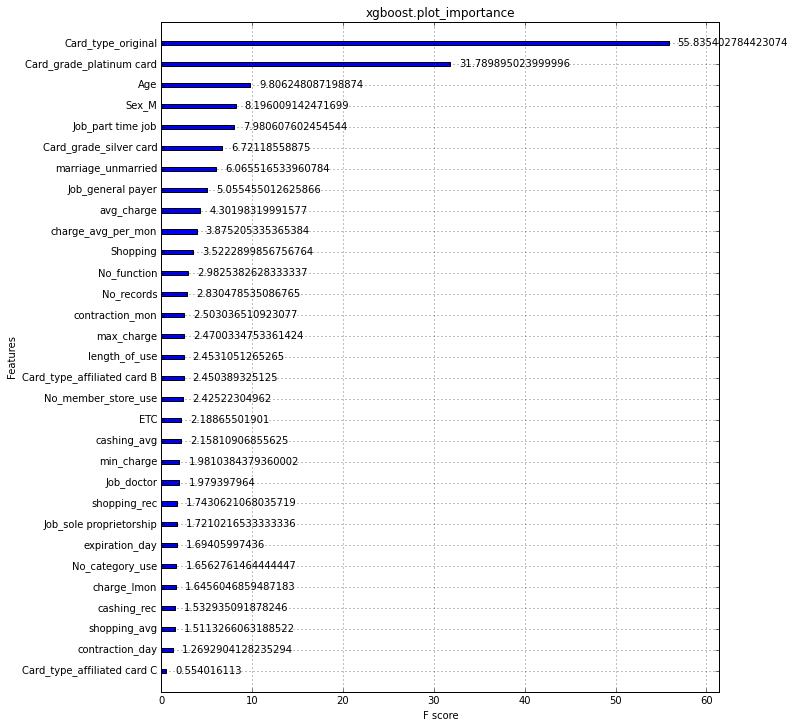

In [285]:
xgb_importances(xgb_clf, 'gain')

By Coverage:

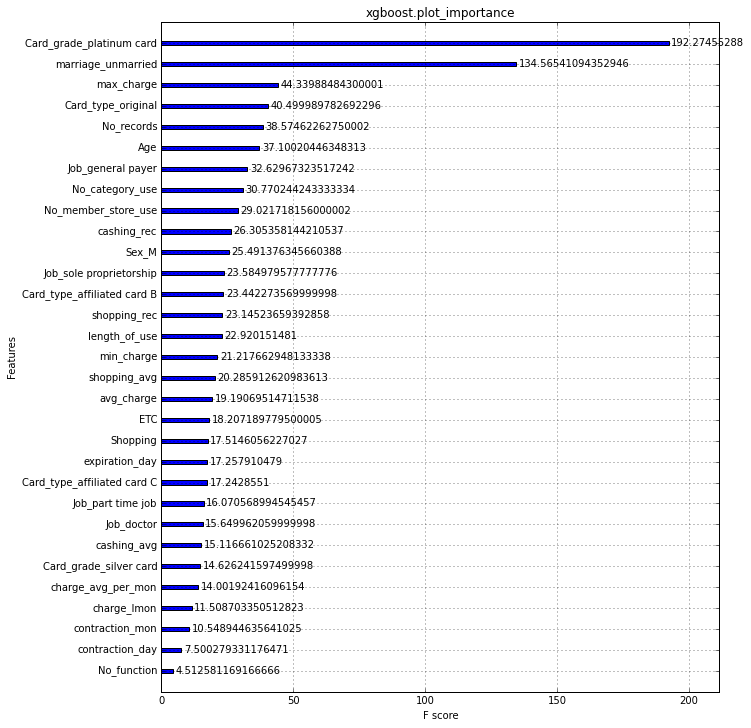

In [286]:
xgb_importances(xgb_clf, 'cover')

# Insight

Both Decision Tree and XGBoost shows similar result yet there is still some differences in features importance, as XGBoost has higher precision and recall hence we derived the insight from XGBoost.

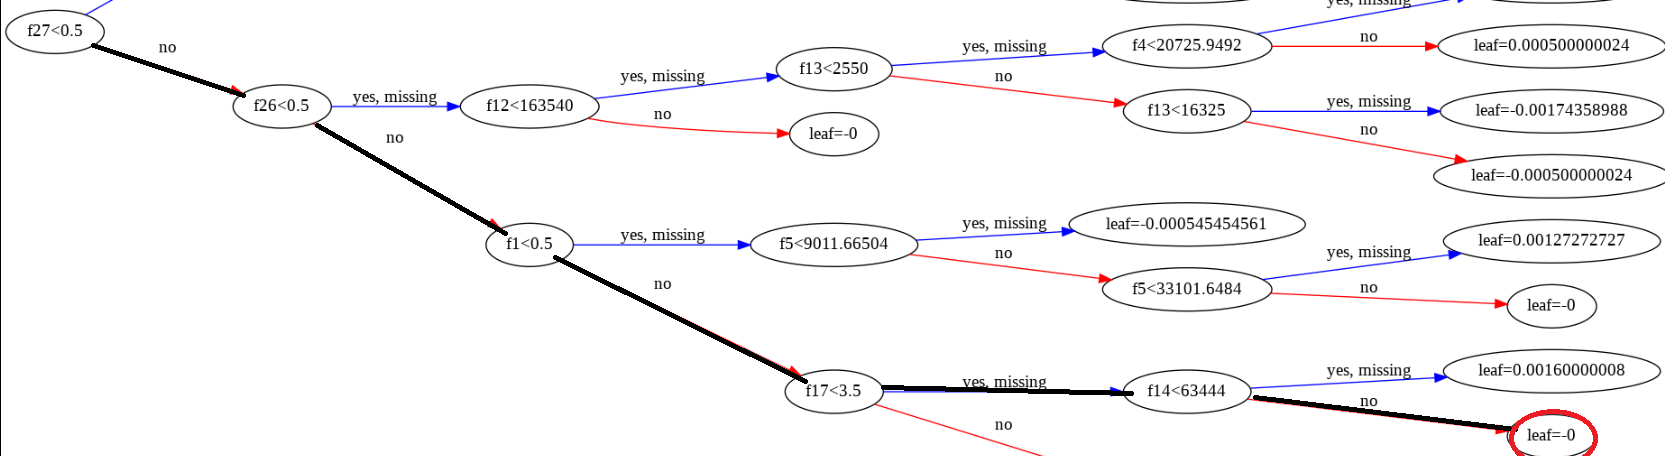

We are taking this nodes for our observation by looking at the features importance output. 

The characteristics are customer who doesn't have an original card, the grade of the card is not platinum, with average charge below 63.440 JPY, and the customer who doesn't use their card for shopping and the cards being contracted on the first and second month of 2003.

In [287]:
df_response = df.loc[(df['Card_type'] != 'original') & (df['Card_grade'] != 'platinum card') & (df['avg_charge'] < 63444) & (df['Shopping'] == 0) & (df['contraction_mon'] < 3.5)]

In [288]:
df_response['Response'].value_counts()
# the node that we observe here fit to the sample value we need, which have more no response class than the one responded
# and the sample is still big enough to represent the data

0    107
1      8
Name: Response, dtype: int64

Now we can see the features of the sample we observe.

1. Gender

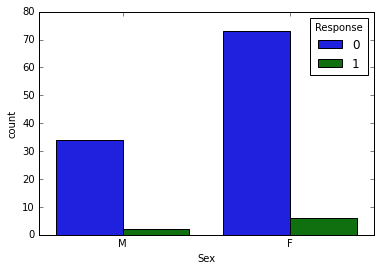

In [289]:
sns.countplot(x = 'Sex', hue = 'Response', data = df_response)
#Most customer: Female

2. Marriage

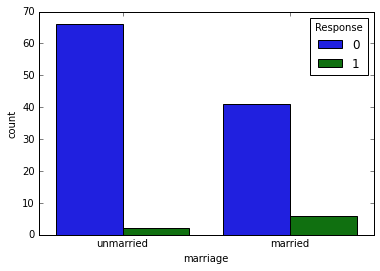

In [290]:
sns.countplot(x = 'marriage', hue = 'Response', data =df_response)
# Mostly unmarried

3. Job

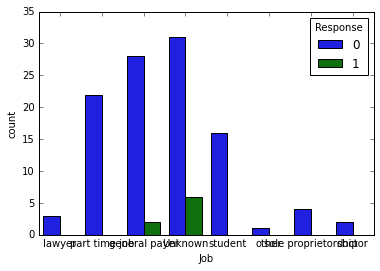

In [291]:
sns.countplot(x = 'Job', hue = 'Response', data =df_response)
#Most Job: Unknown, general payer, or part timer

However, as job has lower feature importance and how most of them actually not responding except the one with 'Unknown' and 'general payer' as their job. We can neglect the Job of most customer in our observation.

4. Card_type

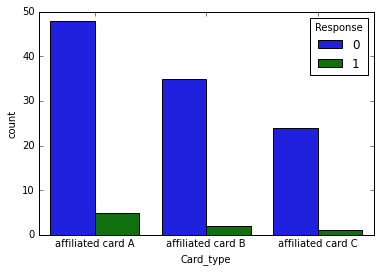

In [292]:
sns.countplot(x = 'Card_type', hue = 'Response', data =df_response)

Card type also doesn't really give many information as the number of response and unresponsive customer probably influenced by the amount of the customer itself, not by the target. This can be seen at how the increase in customer from type C to A followed by increase of the target (both responsive and unresponsive). 

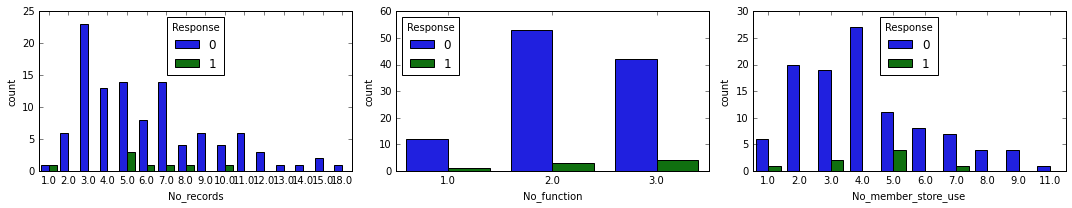

In [293]:
feature = ['No_records', 'No_function', 'No_member_store_use']
plt.figure(figsize=(15,3))
for i in range(0,len(feature)):
  plt.subplot(1, len(feature), i+1)
  sns.countplot(x = feature[i], hue = 'Response', data = df_response)
  plt.tight_layout()


This shows that people with number of records on their credit card more than 1 tend to show no response, except people who have 5,6,8, and 10 records. While, No_function has similar case with card_type so we can neglect them. 

For No_member_store almost all customer in this observation is not responding except the one with membership in 1,5, and 7 store with their card.

2. Numerical value

Before doing the numerical observation for insight it's better to drop the feature that aren't as important from features_importance and the one we have observed.

In [294]:
df_response.drop(['Response', 'Shopping', 'Cashing', 'min_charge',  'ETC', 'No_records', 'No_function', 'No_category_use', 'No_member_store_use', 'contraction_day', 'contraction_mon', 'expiration_day', 'expiration_month'], axis=1).describe()

,Age,shopping_avg,cashing_avg,shopping_rec,cashing_rec,max_charge,avg_charge,charge_avg_per_mon,charge_lmon,length_of_use
count,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000
mean,35.043478,20801.547739,20691.322609,20562.608696,21310.956522,50132.521739,21278.052174,23520.339130,24468.347826,692.252174
std,11.690746,20095.377455,23570.665113,22387.740775,29524.003733,45715.613918,14739.654727,16985.762983,29068.484711,258.183154
min,14.000000,0.000000,0.000000,0.000000,0.000000,3790.000000,2937.000000,2937.000000,2070.000000,0.000000
25%,28.000000,5825.000000,4635.000000,3860.000000,4115.000000,16015.000000,8903.000000,8903.000000,6660.000000,579.500000
50%,34.000000,14737.500000,14780.000000,11070.000000,12610.000000,39190.000000,18052.000000,20213.000000,15510.000000,762.000000
75%,42.000000,28987.150000,26307.500000,33110.000000,25970.000000,71240.000000,29250.000000,32542.500000,30735.000000,884.000000
max,74.000000,90700.000000,164200.000000,115710.000000,203510.000000,279730.000000,62282.000000,73701.000000,203510.000000,1004.000000


The customer average and median age is around 33 and 34 years old.

*   The average of spending from shopping or cashing is around 21.000-23.000 JPY with median around 15.000-17.000, although cashing is not an important feature, we can use this information for future marketing.
*   We can also see that this amount is getting lower in recent months
*   max_charge is 40.000-50.000 JPY
*   The charge monthly is around 23.000 JPY, however in recent month (charge_lmon) there are some changes, such as:
their average credit charge is increasing because customer in 25% upper range on this observation is spending more, yet the 75% in the lower range is decreasing their spending by almost 30% of it.
*   The customer in this observation mostly opened their account in 2001.

Visualization of Numerical features in observation

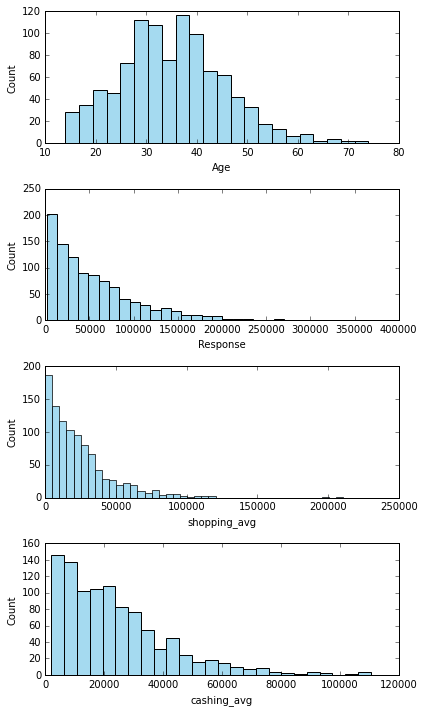

In [295]:
num_features = ['Age', 'max_charge', 'shopping_avg', 'avg_charge']
plt.figure(figsize=(6,10))
for i in range(0, len(num_features)):
  plt.subplot(4, 1, i+1)
  sns.histplot(x=df[num_features[i]], color = 'skyblue')
  plt.xlabel(df_numeric[i])
  plt.tight_layout()